In [1]:
# Part 5: Actionable Recommendations

from utils import *
from math import pi
from pandas.plotting import scatter_matrix

setup_plotting_style()
print_section_header("PART 6: PAPER-READY VISUALIZATIONS")

# ============================================================================
# LOAD DATA
# ============================================================================
df_models, df_class_stats, df_confusion = load_all_data()
pred_cols, all_classes = get_pred_columns(df_confusion)

print(f"\nTotal Models: {df_confusion['model_name'].nunique()}")
print(f"Total Classes: {len(all_classes)}")


PART 6: PAPER-READY VISUALIZATIONS

Total Models: 12
Total Classes: 38



FIGURE 1: AGGREGATED CONFUSION MATRIX
Saved figure: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\photos\paper_fig1_aggregated_confusion.png


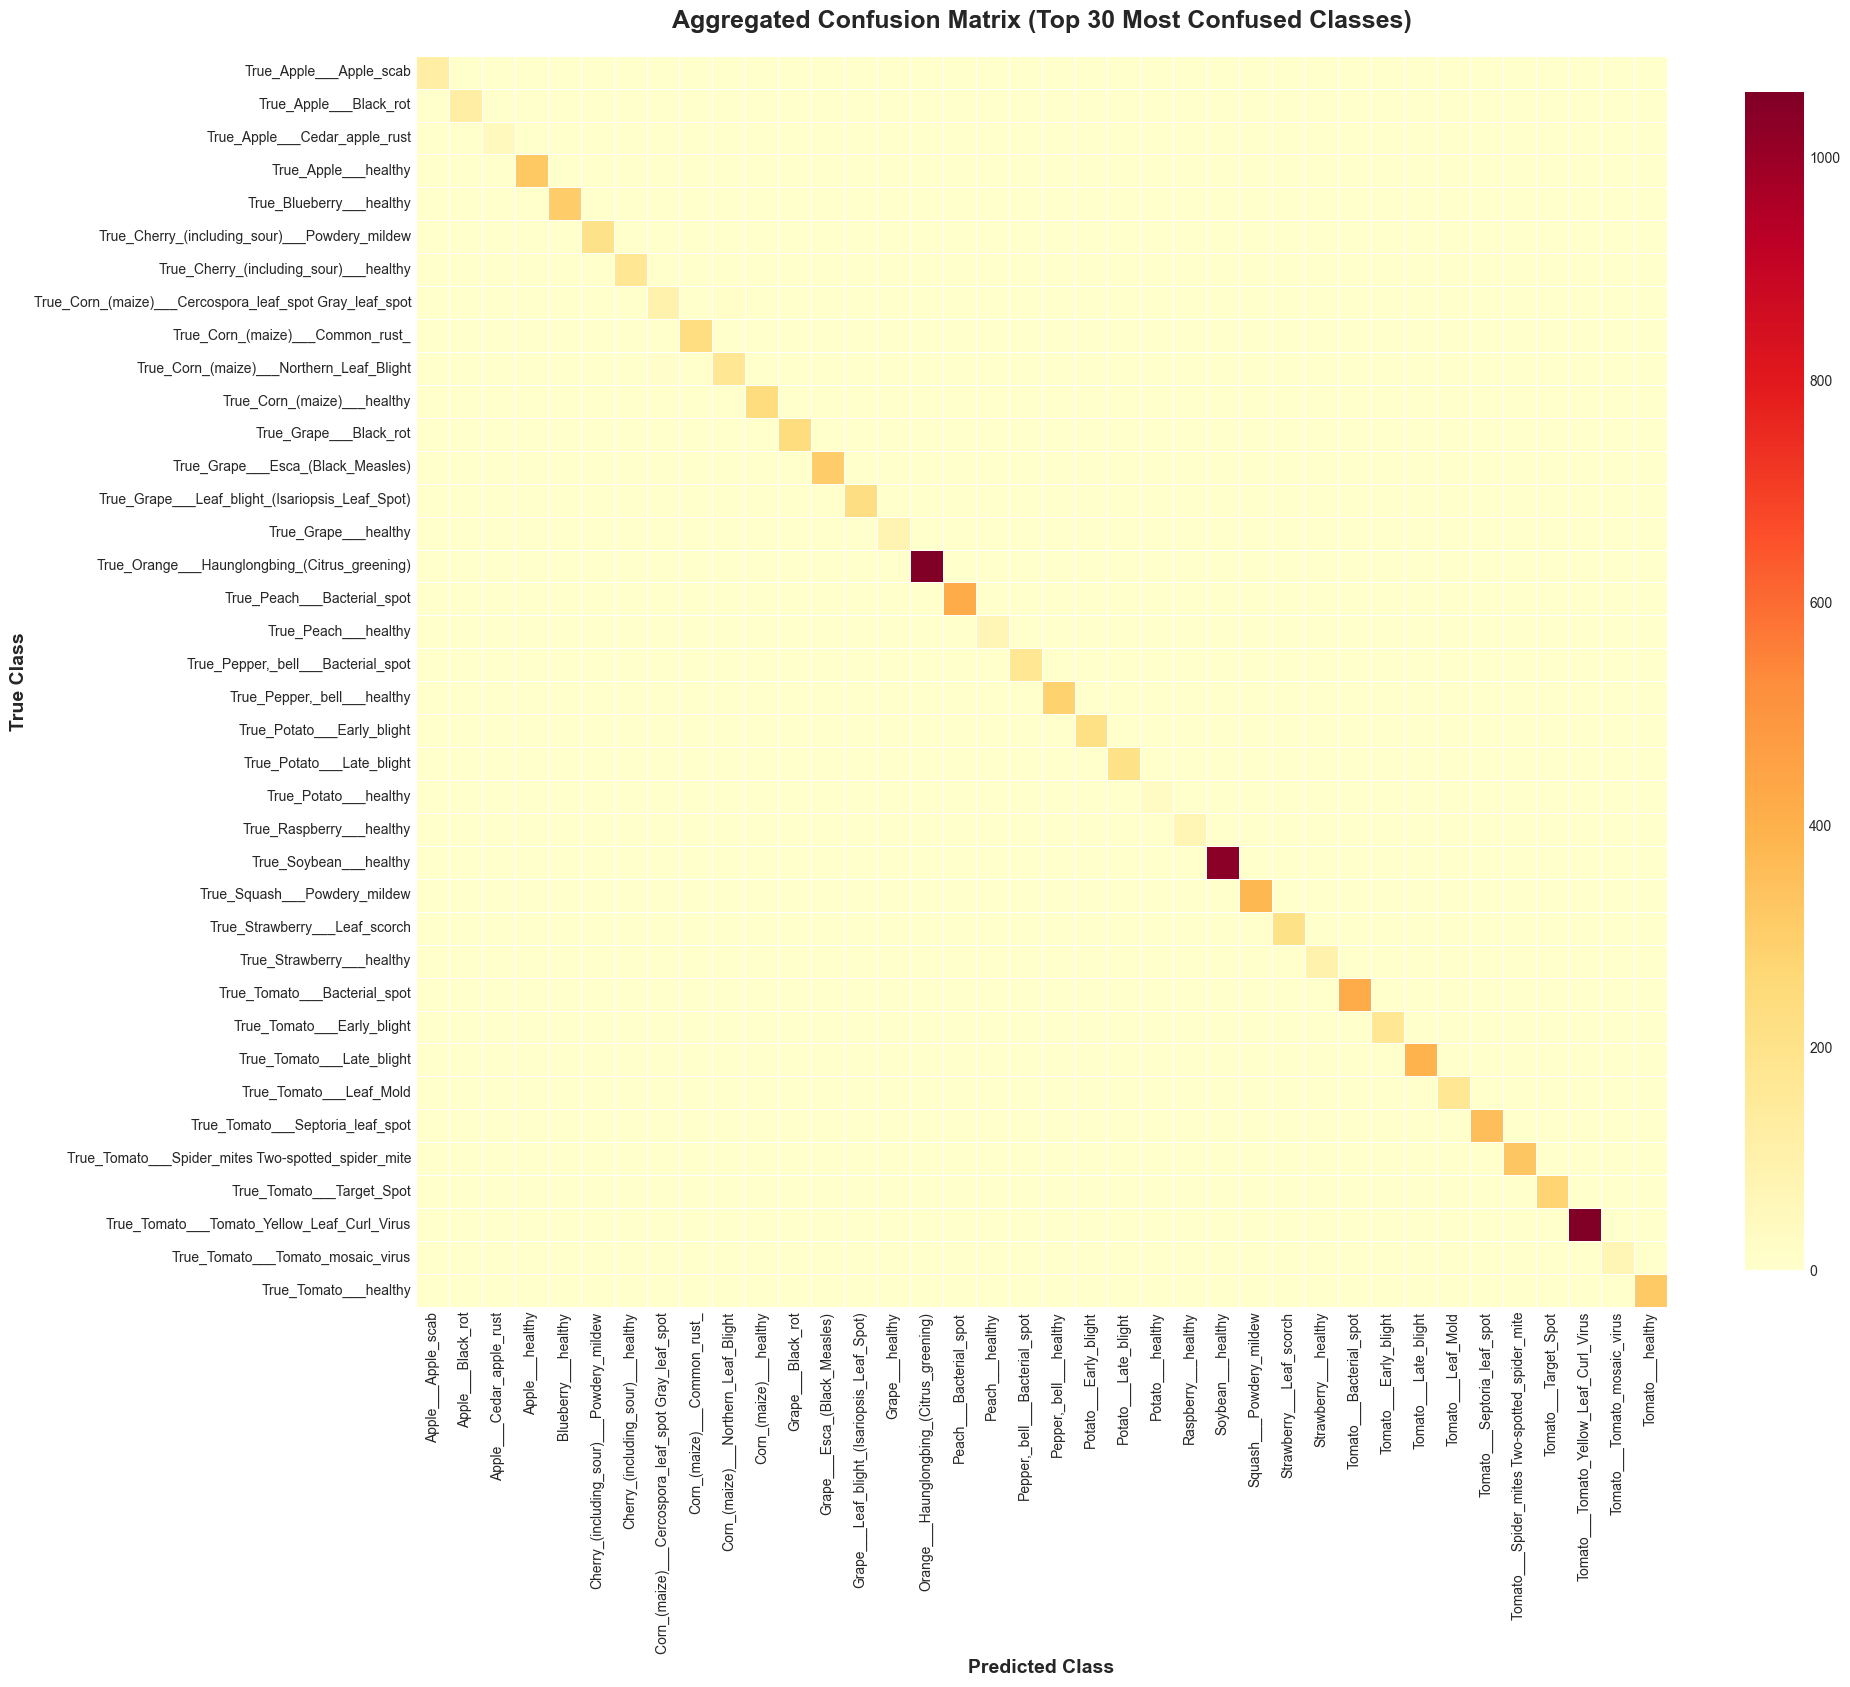

In [2]:
# FIGURE 1: AGGREGATED CONFUSION MATRIX
# ============================================================================
print_section_header("FIGURE 1: AGGREGATED CONFUSION MATRIX")

avg_confusion = aggregate_confusion_matrix(df_confusion, pred_cols, top_n=30)

fig, ax = plt.subplots(figsize=(20, 18))
sns.heatmap(avg_confusion, annot=False, fmt='.1f', cmap='YlOrRd',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Aggregated Confusion Matrix (Top 30 Most Confused Classes)', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Class', fontsize=14, fontweight='bold')
ax.set_ylabel('True Class', fontsize=14, fontweight='bold')

save_figure('paper_fig1_aggregated_confusion.png')
plt.show()


FIGURE 2: SCATTER PLOT MATRIX
Saved figure: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\photos\paper_fig2_scatter_matrix.png


<Figure size 1800x1800 with 0 Axes>

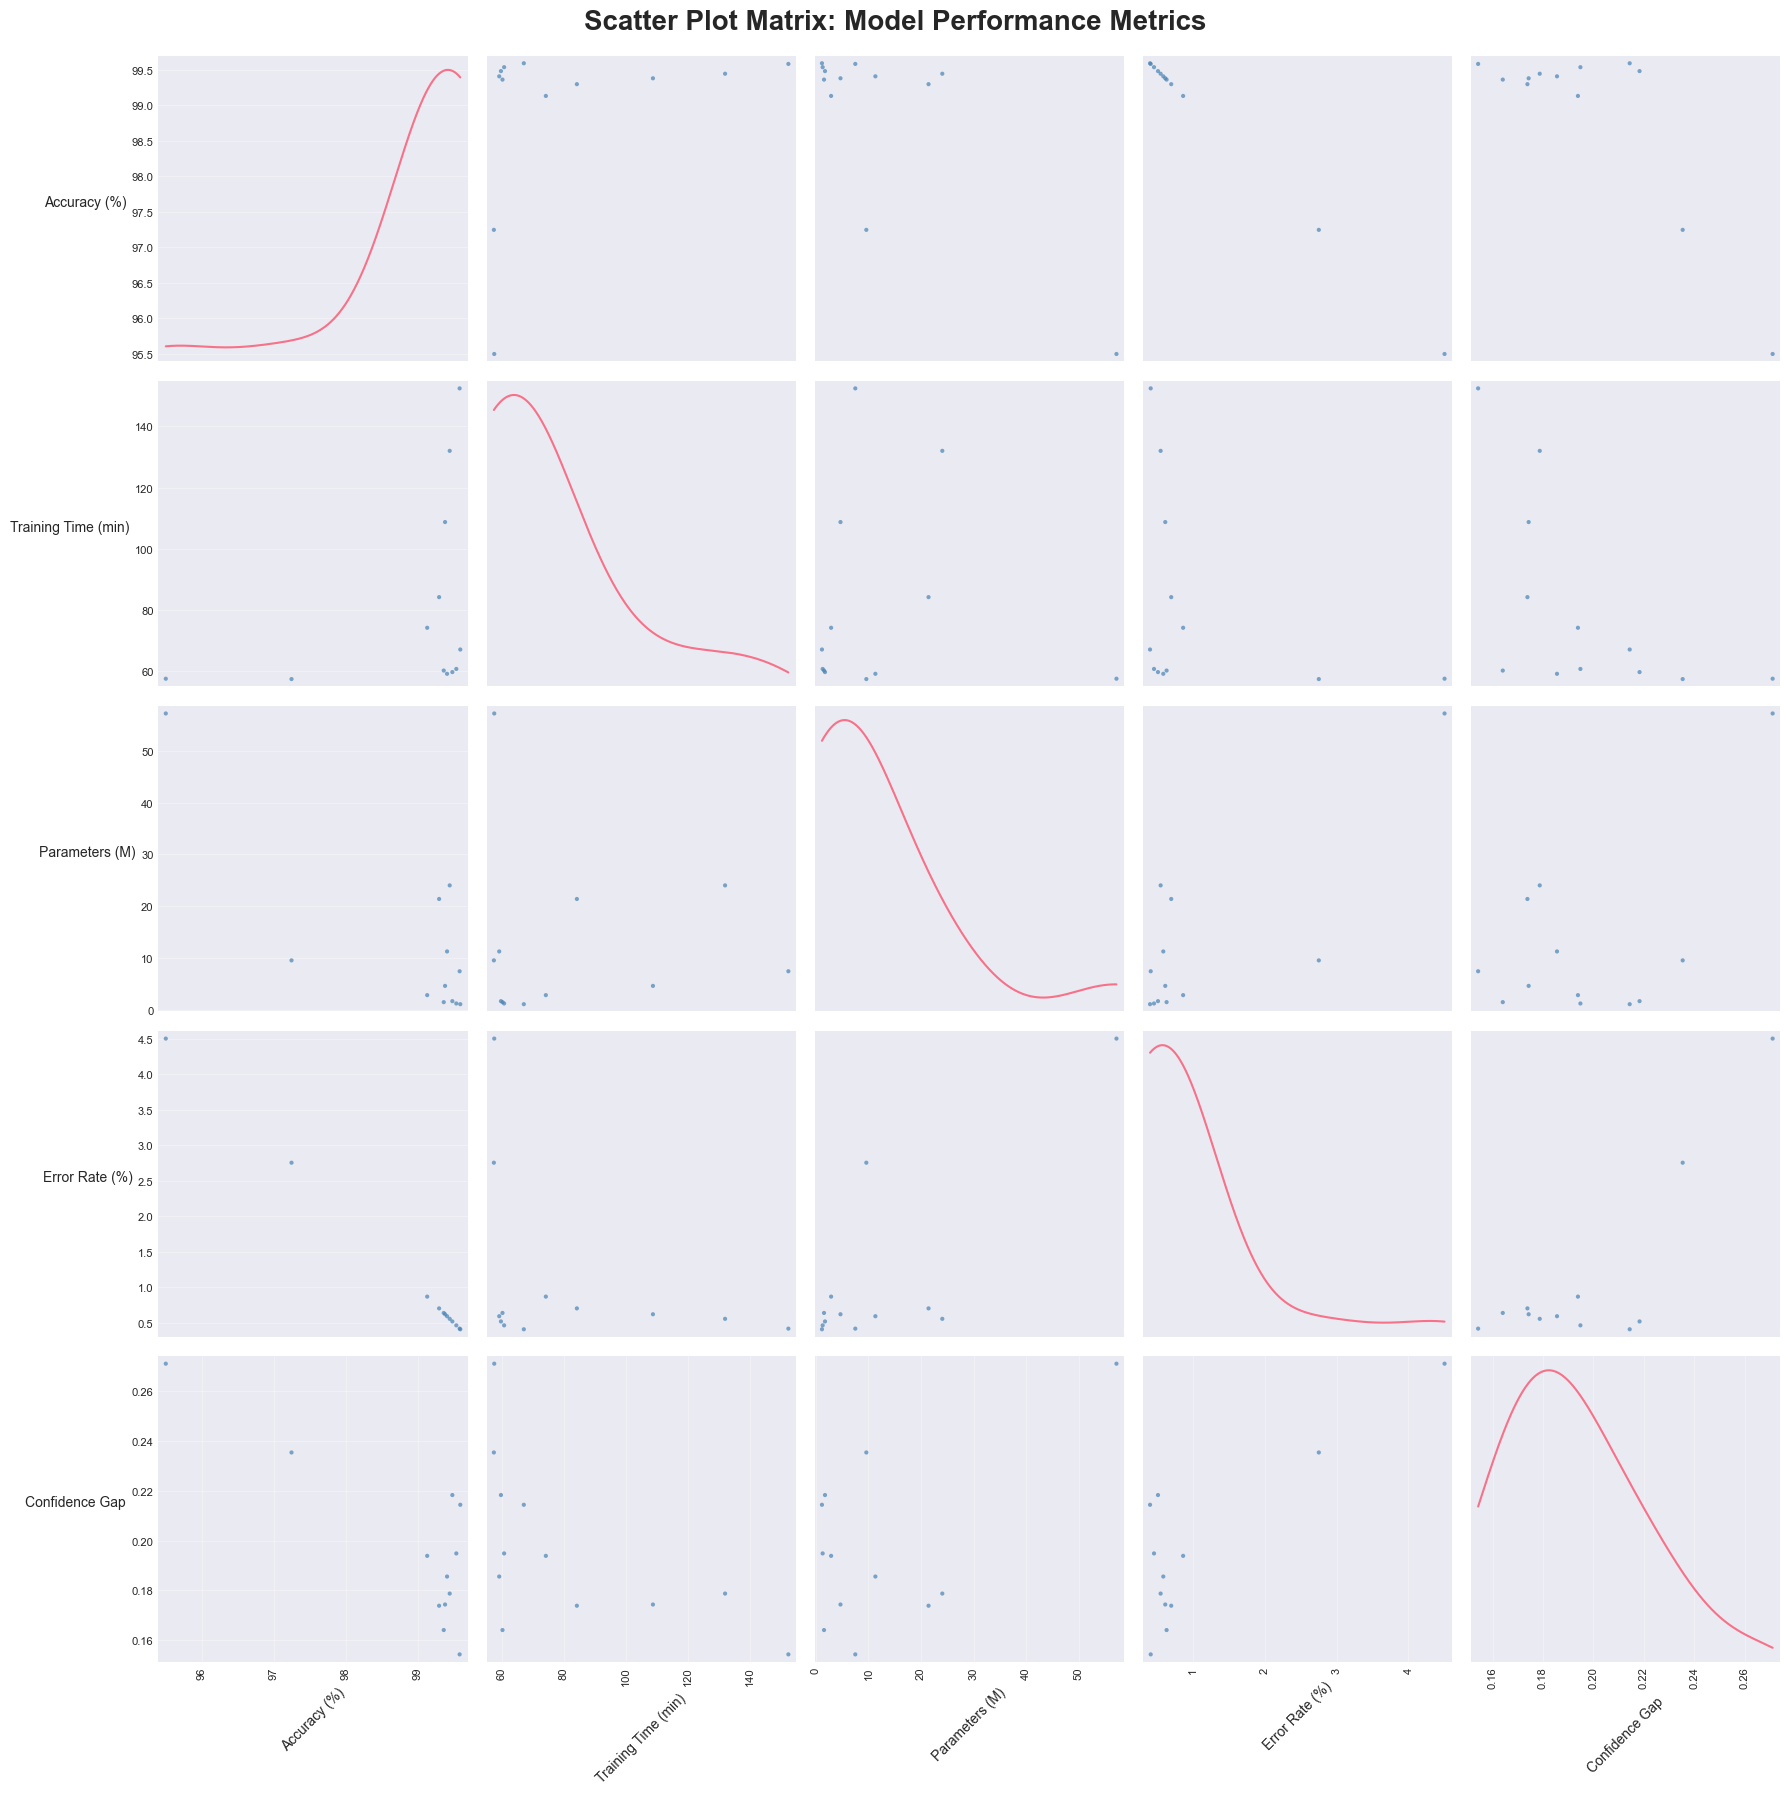

In [3]:
# FIGURE 2: SCATTER PLOT MATRIX
# ============================================================================
print_section_header("FIGURE 2: SCATTER PLOT MATRIX")

metrics_subset = df_models[['Final_Accuracy', 'Training_Time_Minutes', 
                             'Parameters_Million', 'Error_Rate', 'Confidence_Gap']].copy()
metrics_subset.columns = ['Accuracy (%)', 'Training Time (min)', 
                          'Parameters (M)', 'Error Rate (%)', 'Confidence Gap']

fig = plt.figure(figsize=(18, 18))
axes = scatter_matrix(metrics_subset, alpha=0.7, figsize=(18, 18), 
                     diagonal='kde', grid=True, color='steelblue')

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(45)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Scatter Plot Matrix: Model Performance Metrics', 
             fontsize=20, fontweight='bold', y=0.995)

save_figure('paper_fig2_scatter_matrix.png')
plt.show()


FIGURE 3: RADAR CHART (Top 5 Models)
Saved figure: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\photos\paper_fig3_radar_chart.png


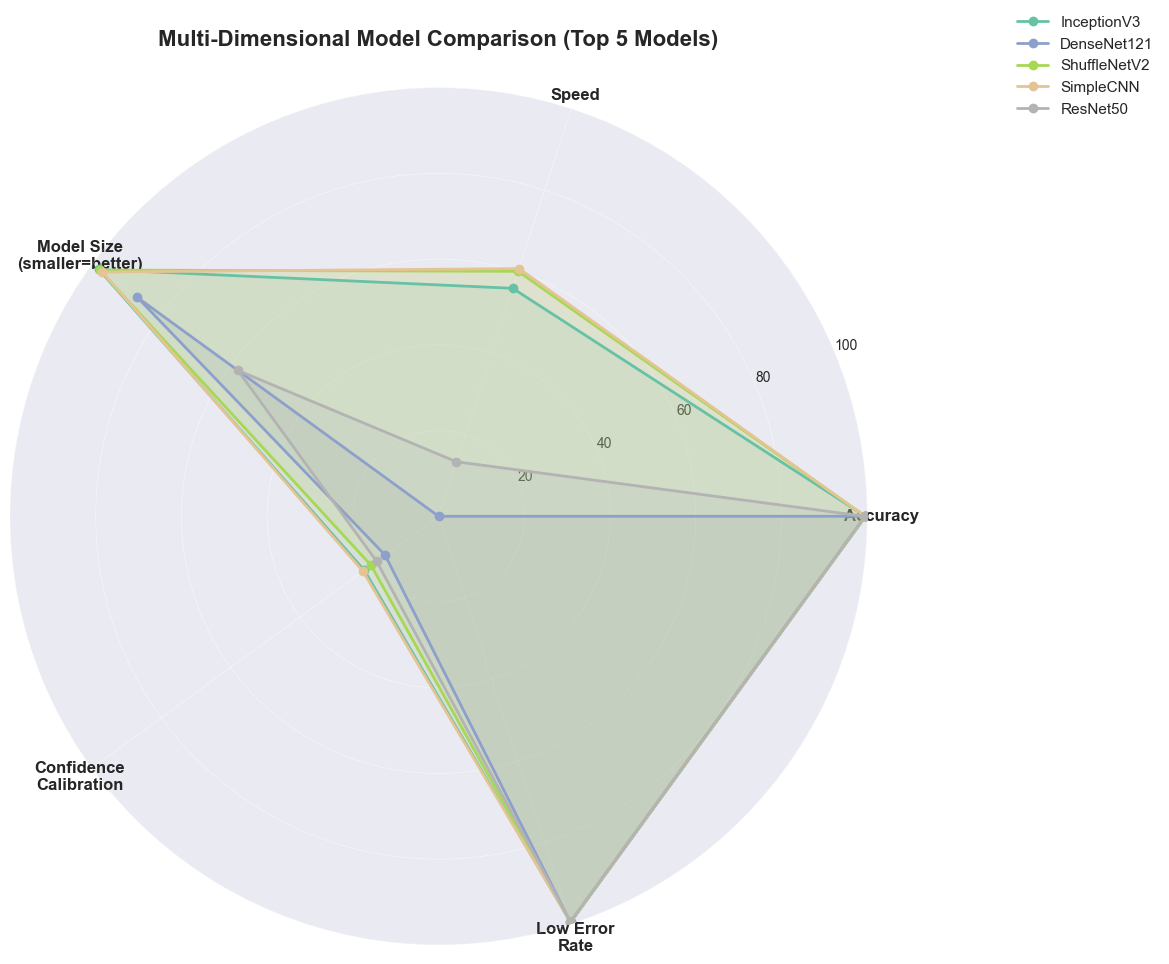

In [4]:
# FIGURE 3: RADAR CHART
# ============================================================================
print_section_header("FIGURE 3: RADAR CHART (Top 5 Models)")

# Calculate normalized scores
df_models['Accuracy_Norm'] = df_models['Final_Accuracy']
df_models['Speed_Norm'] = 100 - (df_models['Training_Time_Minutes'] / 
                                  df_models['Training_Time_Minutes'].max() * 100)
df_models['Size_Norm'] = 100 - (df_models['Parameters_Million'] / 
                                df_models['Parameters_Million'].max() * 100)
df_models['Confidence_Norm'] = df_models['Confidence_Gap'] * 100
df_models['LowError_Norm'] = 100 - df_models['Error_Rate']

top_5_models = df_models.nlargest(5, 'Final_Accuracy')

categories = ['Accuracy', 'Speed', 'Model Size\n(smaller=better)', 
              'Confidence\nCalibration', 'Low Error\nRate']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
colors = plt.cm.Set2(np.linspace(0, 1, len(top_5_models)))

for idx, (_, row) in enumerate(top_5_models.iterrows()):
    values = [
        row['Accuracy_Norm'],
        row['Speed_Norm'],
        row['Size_Norm'],
        row['Confidence_Norm'],
        row['LowError_Norm']
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12, fontweight='bold')
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'], size=10)
ax.grid(True, linewidth=0.5, alpha=0.5)
ax.set_title('Multi-Dimensional Model Comparison (Top 5 Models)', 
             size=16, fontweight='bold', pad=30)
plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1), fontsize=11)

save_figure('paper_fig3_radar_chart.png')
plt.show()


FIGURE 4: PARETO FRONTIER
Saved figure: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\photos\paper_fig4_pareto_frontier.png


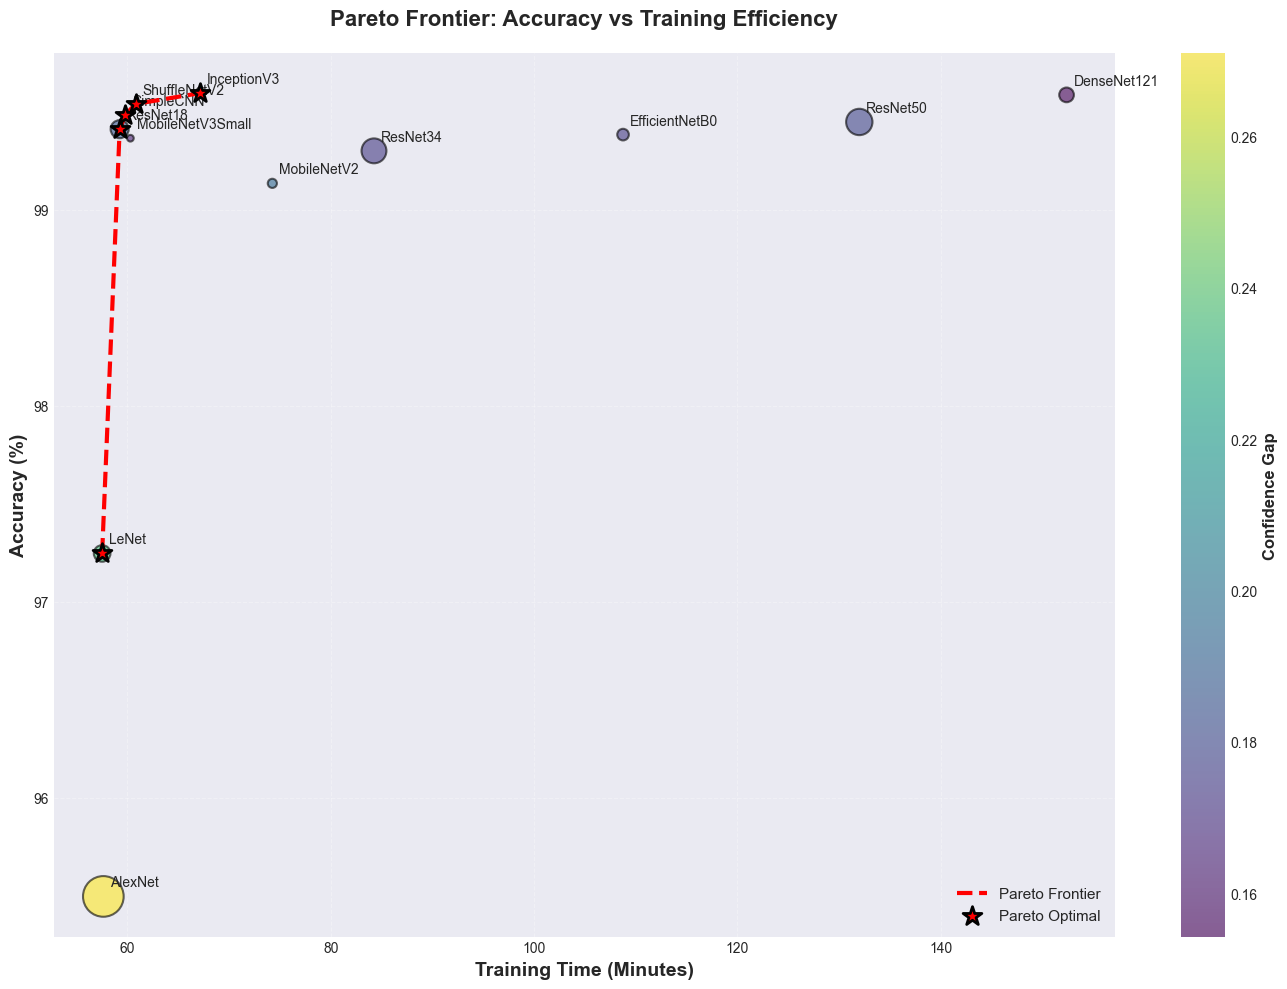

In [5]:
# FIGURE 4: PARETO FRONTIER
# ============================================================================
print_section_header("FIGURE 4: PARETO FRONTIER")

fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(df_models['Training_Time_Minutes'], 
                    df_models['Final_Accuracy'],
                    s=df_models['Parameters_Million']*15,
                    c=df_models['Confidence_Gap'],
                    cmap='viridis', alpha=0.6, edgecolor='black', linewidth=1.5)

for idx, row in df_models.iterrows():
    ax.annotate(row['Model'], 
                (row['Training_Time_Minutes'], row['Final_Accuracy']),
                fontsize=10, ha='left', va='bottom', 
                xytext=(5, 5), textcoords='offset points')

# Calculate Pareto frontier
pareto_points = []
for i, row in df_models.iterrows():
    is_pareto = True
    for j, other in df_models.iterrows():
        if i != j:
            if (other['Final_Accuracy'] >= row['Final_Accuracy'] and 
                other['Training_Time_Minutes'] <= row['Training_Time_Minutes'] and
                (other['Final_Accuracy'] > row['Final_Accuracy'] or 
                 other['Training_Time_Minutes'] < row['Training_Time_Minutes'])):
                is_pareto = False
                break
    if is_pareto:
        pareto_points.append(row)

if pareto_points:
    pareto_df = pd.DataFrame(pareto_points).sort_values('Training_Time_Minutes')
    ax.plot(pareto_df['Training_Time_Minutes'], pareto_df['Final_Accuracy'],
            'r--', linewidth=3, label='Pareto Frontier', zorder=5)
    ax.scatter(pareto_df['Training_Time_Minutes'], pareto_df['Final_Accuracy'],
               s=200, c='red', marker='*', edgecolor='black', 
               linewidth=2, zorder=10, label='Pareto Optimal')

cbar = plt.colorbar(scatter, ax=ax, label='Confidence Gap')
cbar.set_label('Confidence Gap', fontsize=12, fontweight='bold')

ax.set_xlabel('Training Time (Minutes)', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('Pareto Frontier: Accuracy vs Training Efficiency', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='lower right')

save_figure('paper_fig4_pareto_frontier.png')
plt.show()


FIGURE 5: PER-MODEL CONFUSION MATRIX GRID
Saved figure: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\photos\paper_fig5_confusion_grid.png
Note: Showing 20 classes per model


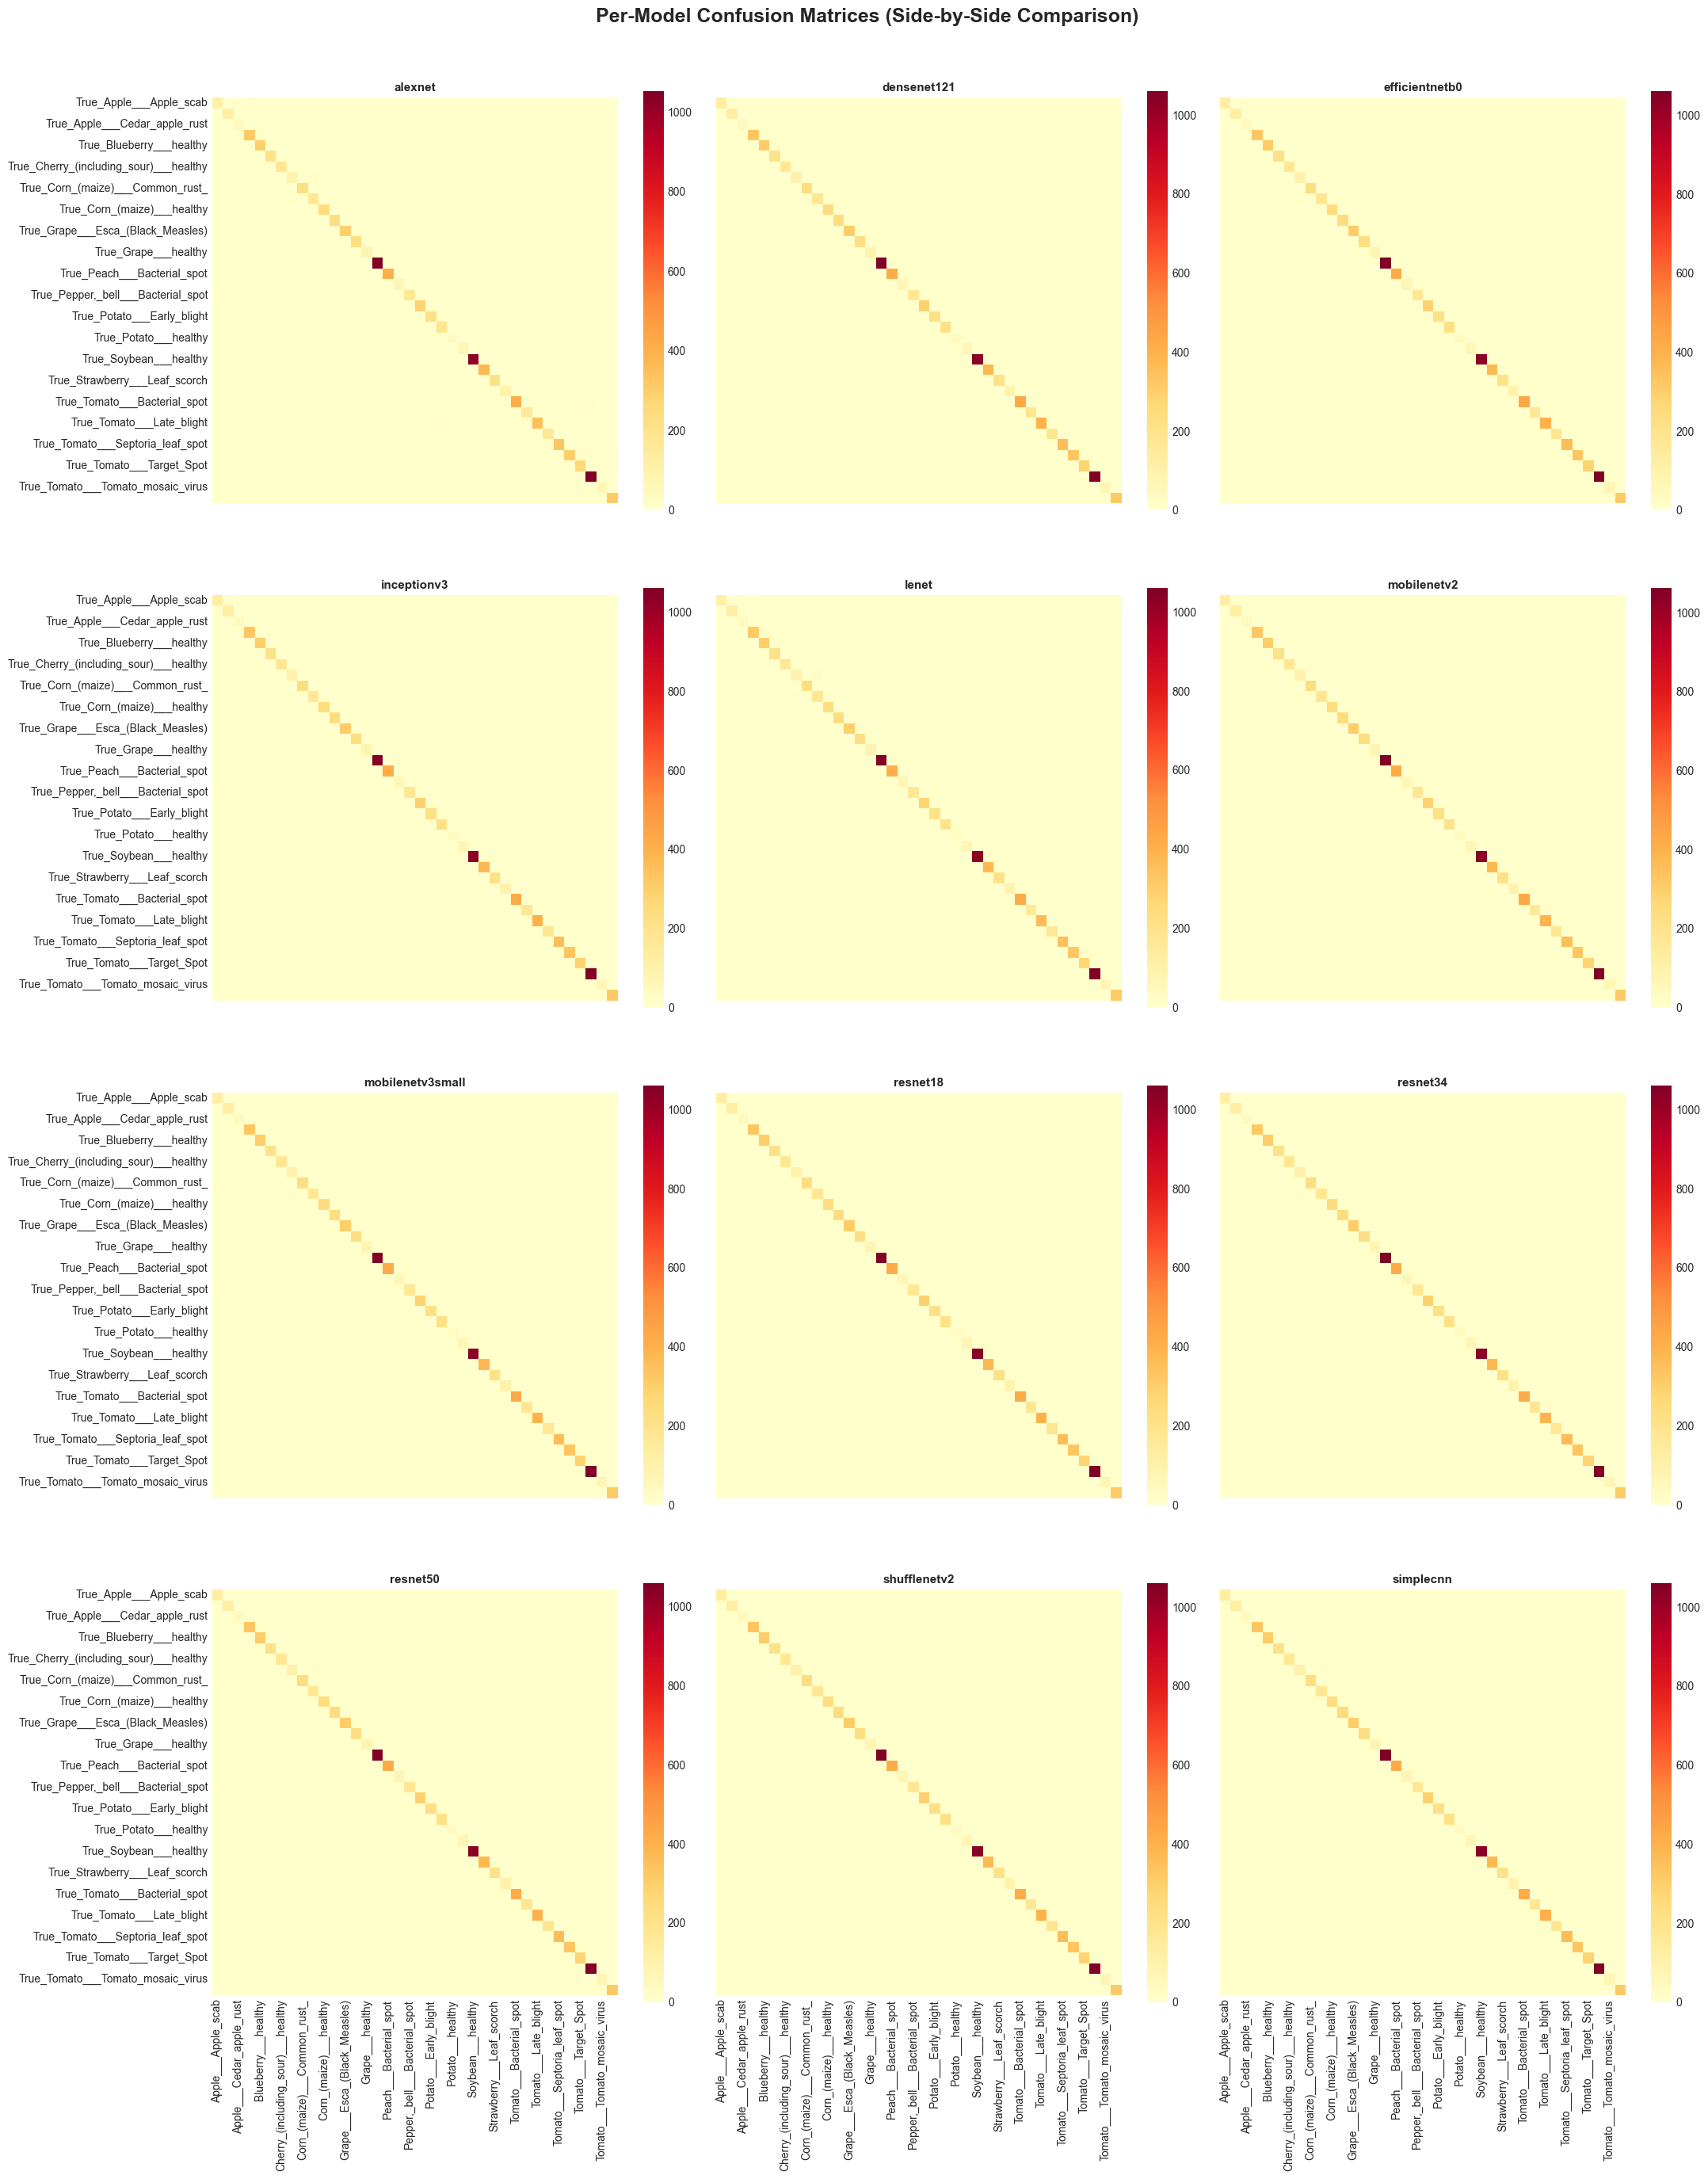

In [6]:
# FIGURE 5: PER-MODEL CONFUSION MATRIX GRID
# ============================================================================
print_section_header("FIGURE 5: PER-MODEL CONFUSION MATRIX GRID")

models = df_confusion['model_name'].unique()
n_models = len(models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 7*n_rows))
axes = axes.flatten() if n_models > 1 else [axes]

# Define show_classes for top 20
show_classes = all_classes[:20] if len(all_classes) > 20 else all_classes

for idx, model in enumerate(models):
    model_data = df_confusion[df_confusion['model_name'] == model]
    conf_matrix = model_data.set_index('Unnamed: 0')[pred_cols]
    conf_matrix.columns = [col.replace('Pred_', '') for col in conf_matrix.columns]
    
    # Subset to top 20 classes
    if len(all_classes) > 20:
        available_classes = [c for c in show_classes if c in conf_matrix.index and c in conf_matrix.columns]
        if len(available_classes) > 0:
            conf_matrix = conf_matrix.loc[available_classes, available_classes]
    
    sns.heatmap(conf_matrix, ax=axes[idx], cmap='YlOrRd', 
               cbar=True, square=True, annot=False,
               cbar_kws={"shrink": 0.8})
    
    model_match = df_models[df_models["Model"] == model]
    if len(model_match) > 0:
        acc = model_match["Final_Accuracy"].values[0]
        title = f'{model}\n(Accuracy: {acc:.2f}%)'
    else:
        title = f'{model}'
    
    axes[idx].set_title(title, fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('')
    
    if idx % n_cols != 0:
        axes[idx].set_yticks([])
    if idx < n_models - n_cols:
        axes[idx].set_xticks([])

for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Per-Model Confusion Matrices (Side-by-Side Comparison)', 
             fontsize=18, fontweight='bold', y=0.995)

save_figure('paper_fig5_confusion_grid.png')
print(f"Note: Showing {len(show_classes)} classes per model")
plt.show()


FIGURE 6: BOX PLOTS
Saved figure: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\photos\paper_fig6_class_variation_boxplot.png


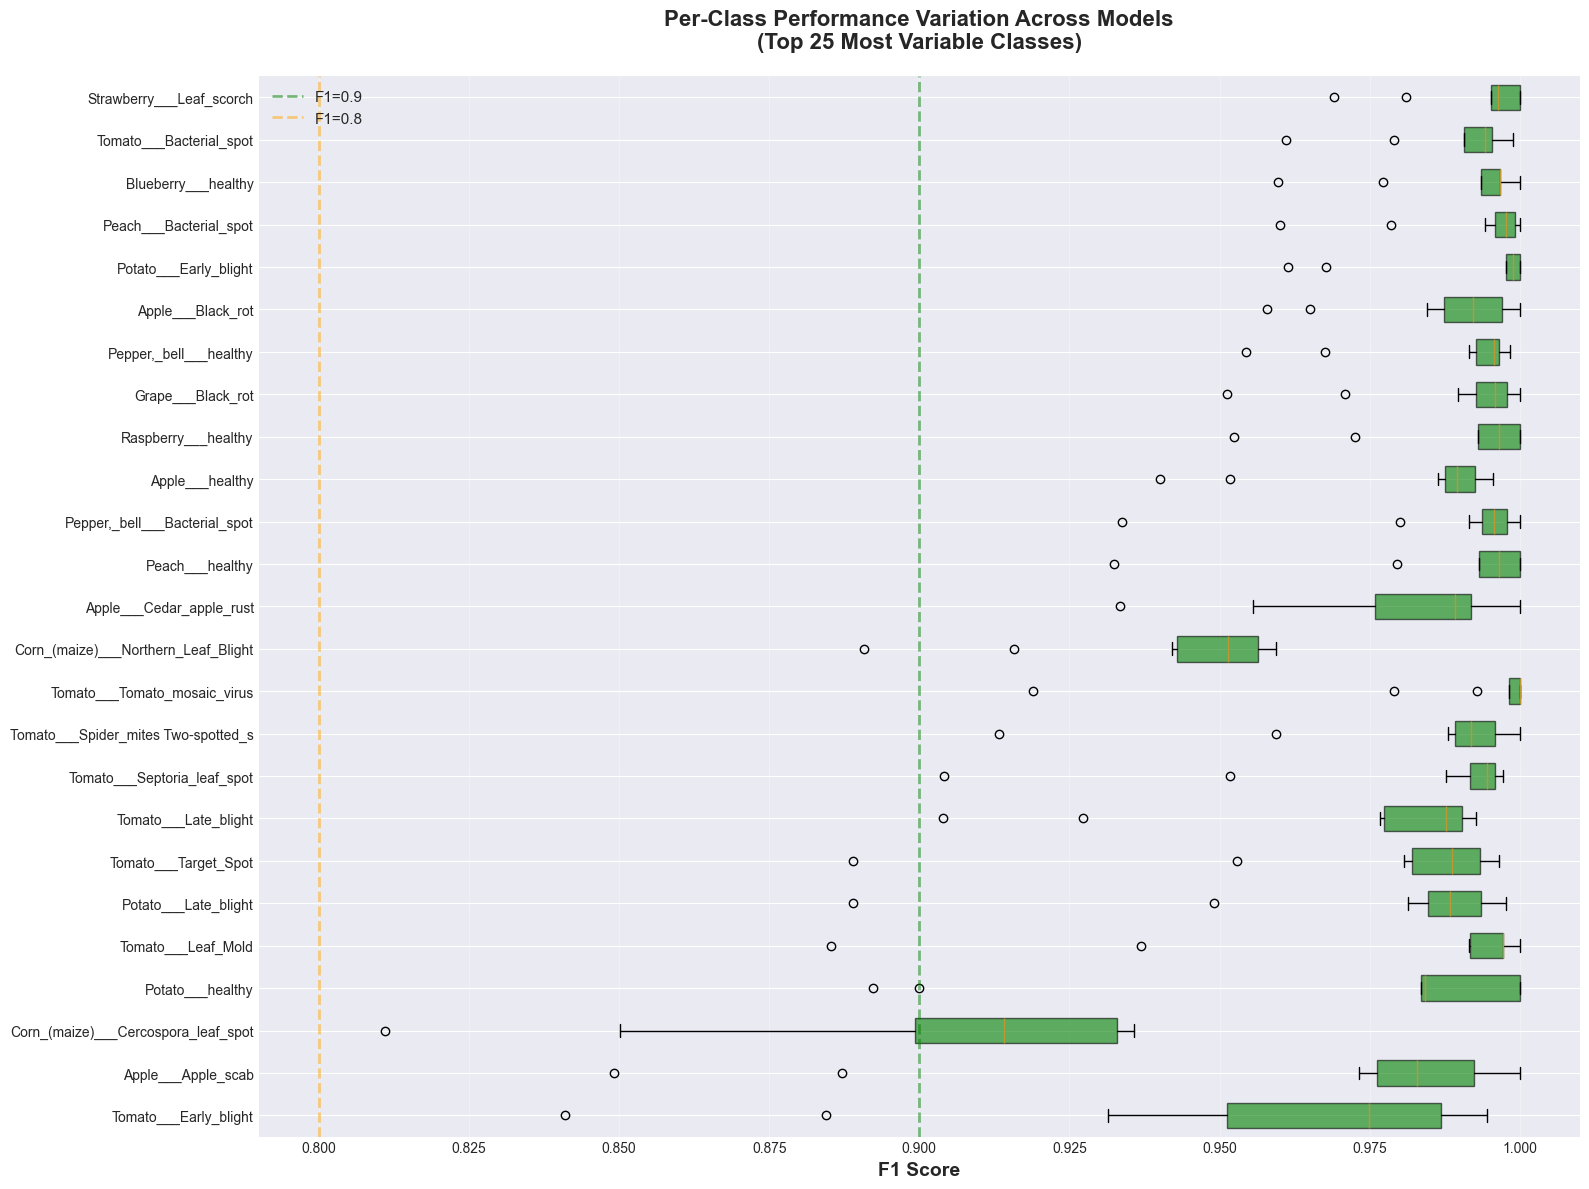

In [7]:
# FIGURE 6: BOX PLOTS
# ============================================================================
print_section_header("FIGURE 6: BOX PLOTS")

class_variance = df_class_stats.groupby('Class')['F1_Score'].agg(['mean', 'std']).reset_index()
class_variance = class_variance.sort_values('std', ascending=False).head(25)

fig, ax = plt.subplots(figsize=(16, 12))

data_for_box = []
labels = []
colors_box = []

for _, row in class_variance.iterrows():
    cls = row['Class']
    class_data = df_class_stats[df_class_stats['Class'] == cls]['F1_Score'].values
    data_for_box.append(class_data)
    labels.append(truncate_label(cls, 35))
    
    mean_f1 = row['mean']
    if mean_f1 >= 0.9:
        colors_box.append('green')
    elif mean_f1 >= 0.8:
        colors_box.append('orange')
    else:
        colors_box.append('red')

bp = ax.boxplot(data_for_box, vert=False, patch_artist=True,
                labels=labels, widths=0.6)

for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_xlabel('F1 Score', fontsize=14, fontweight='bold')
ax.set_title('Per-Class Performance Variation Across Models\n(Top 25 Most Variable Classes)', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.axvline(x=0.9, color='green', linestyle='--', linewidth=2, alpha=0.5, label='F1=0.9')
ax.axvline(x=0.8, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='F1=0.8')
ax.legend(fontsize=11)

save_figure('paper_fig6_class_variation_boxplot.png')
plt.show()


FIGURE 7: COMPREHENSIVE OVERVIEW
Saved figure: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\photos\paper_fig7_comprehensive_overview.png


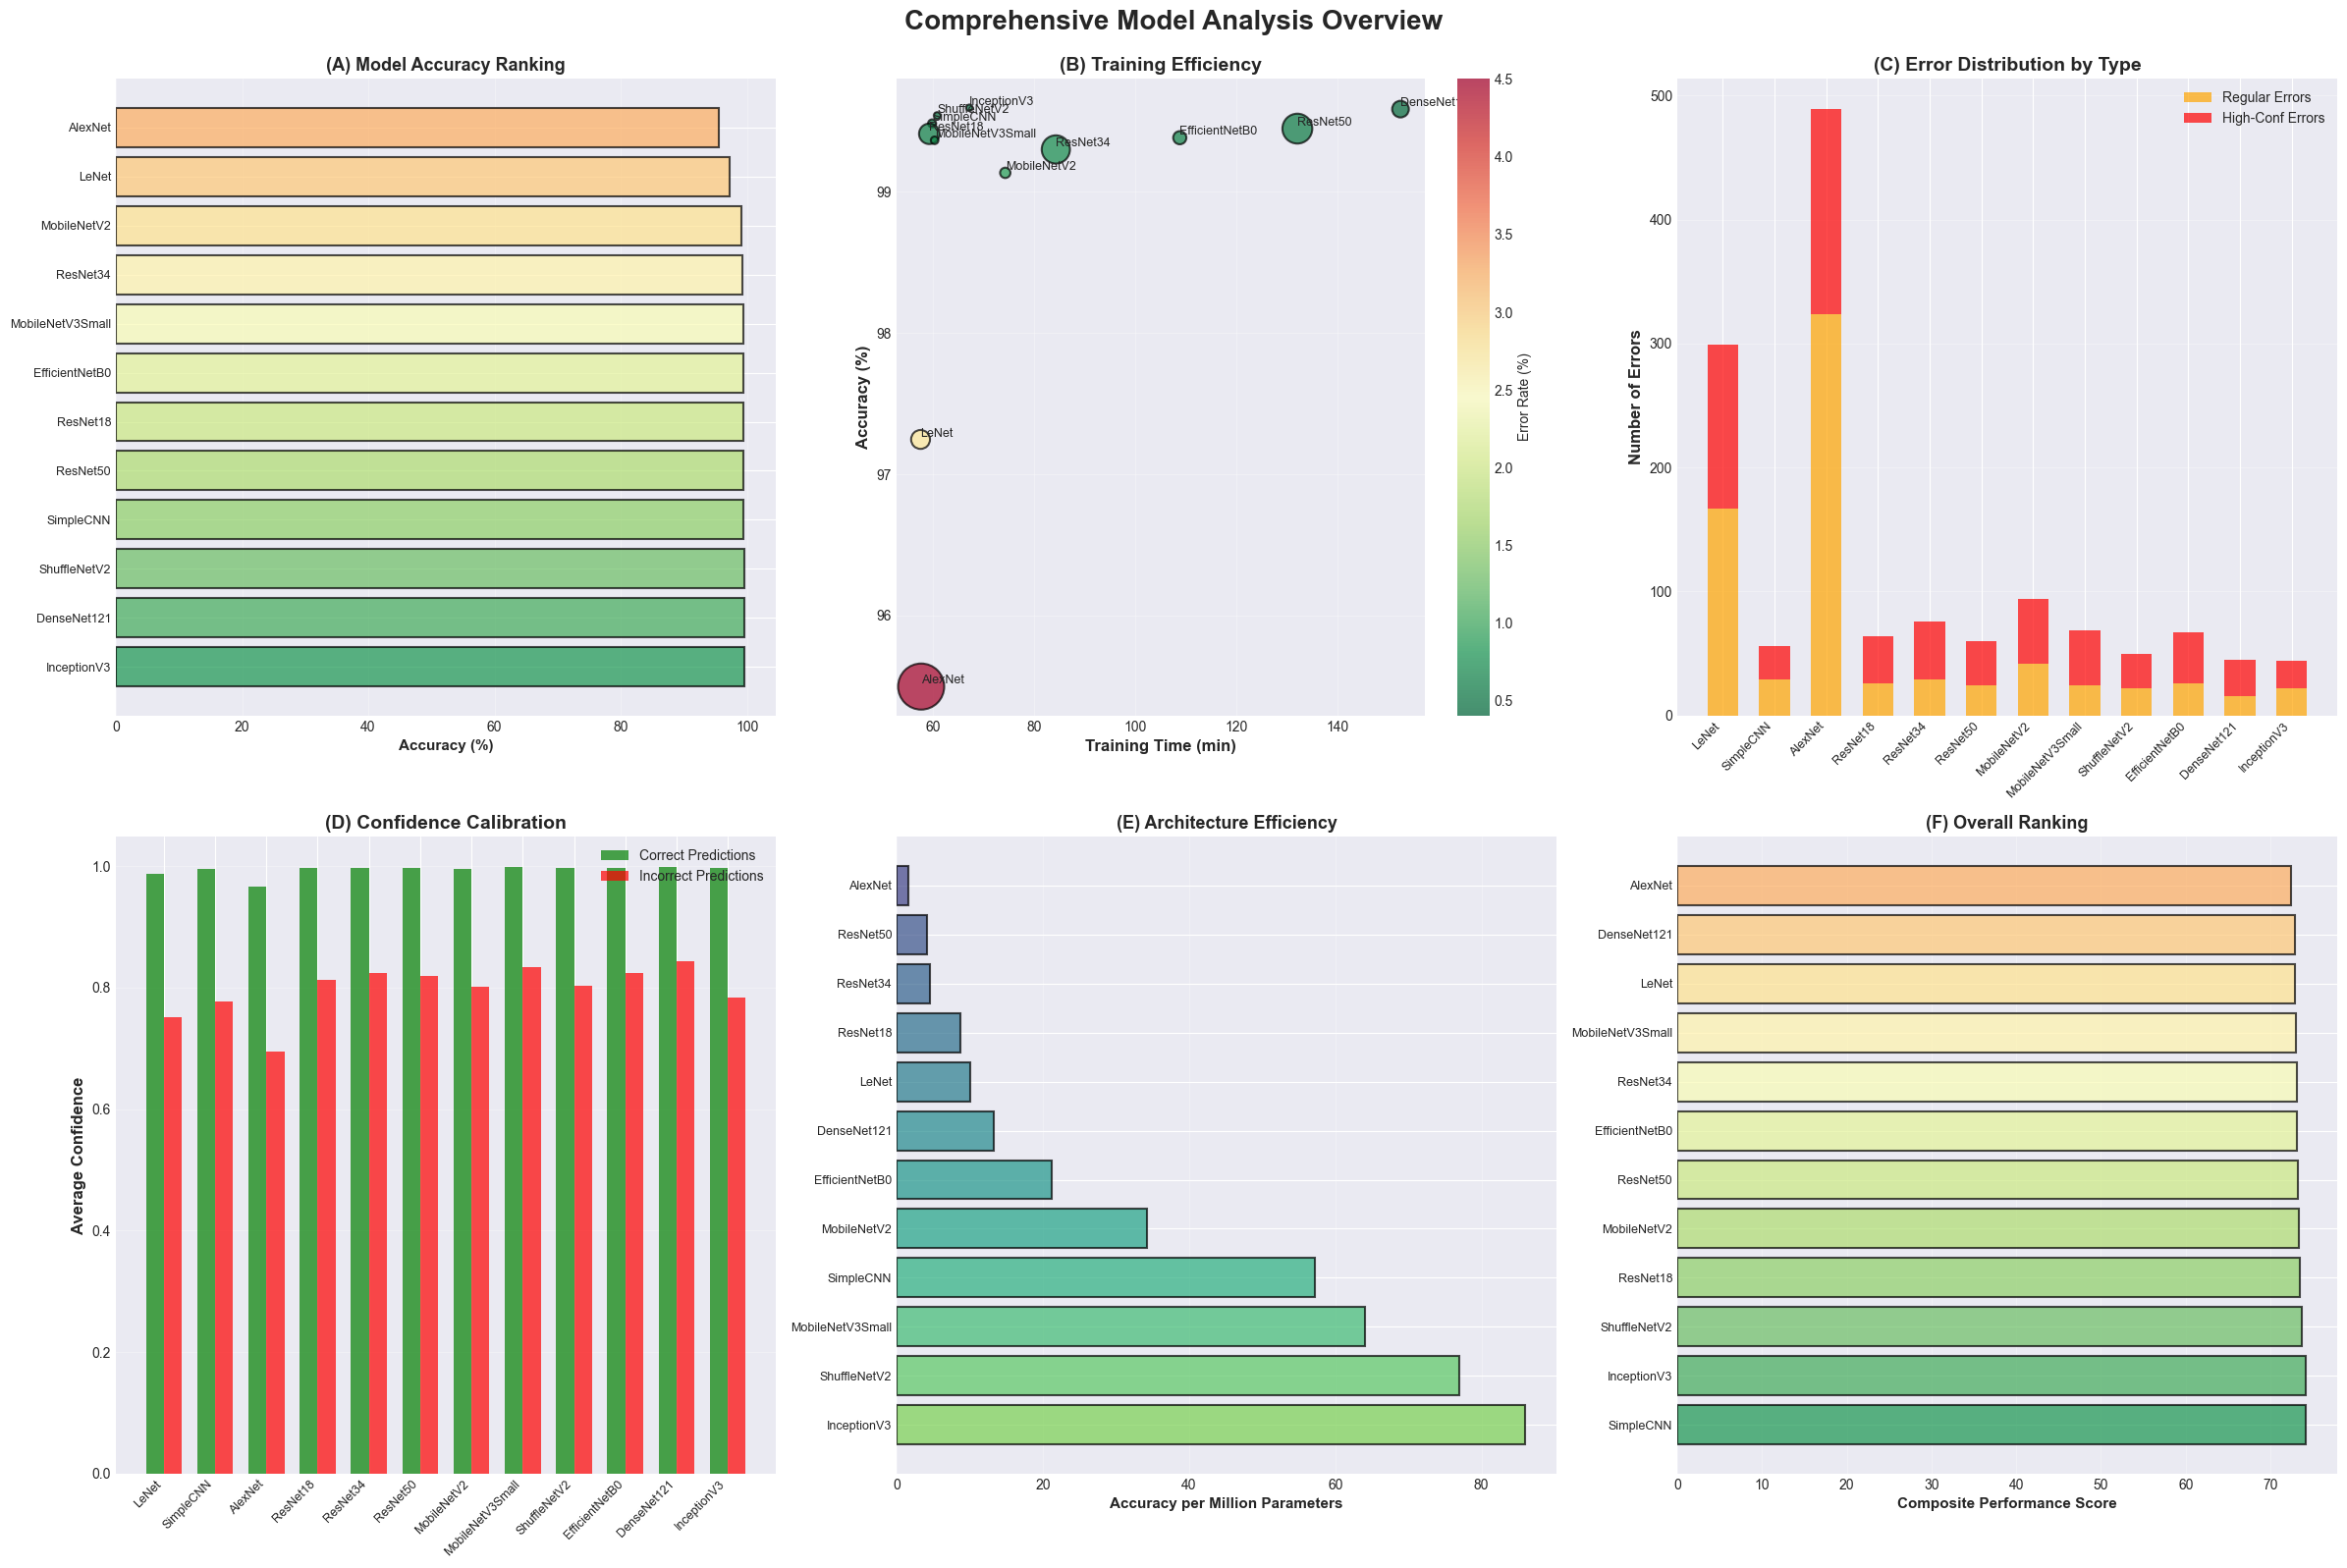

In [8]:
# FIGURE 7: COMPREHENSIVE OVERVIEW
# ============================================================================
print_section_header("FIGURE 7: COMPREHENSIVE OVERVIEW")

fig = plt.figure(figsize=(24, 16))

# Panel 1: Model Accuracy Ranking
ax1 = plt.subplot(2, 3, 1)
models_sorted = df_models.sort_values('Final_Accuracy', ascending=True)
colors_acc = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(models_sorted)))
create_horizontal_bar(ax1, models_sorted['Final_Accuracy'].values,
                     models_sorted['Model'].values,
                     '(A) Model Accuracy Ranking',
                     'Accuracy (%)', colors_acc)

# Panel 2: Training Time vs Accuracy
ax2 = plt.subplot(2, 3, 2)
scatter2 = ax2.scatter(df_models['Training_Time_Minutes'], 
                       df_models['Final_Accuracy'],
                       s=df_models['Parameters_Million']*20,
                       c=df_models['Error_Rate'], cmap='RdYlGn_r',
                       alpha=0.7, edgecolor='black', linewidth=1.5)
for idx, row in df_models.iterrows():
    ax2.annotate(row['Model'], 
                (row['Training_Time_Minutes'], row['Final_Accuracy']),
                fontsize=9, ha='left', va='bottom')
ax2.set_xlabel('Training Time (min)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('(B) Training Efficiency', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Error Rate (%)')

# Panel 3: Error Type Distribution
ax3 = plt.subplot(2, 3, 3)
total_errors = df_models['Total_Errors'].values
high_conf_errors = df_models['High_Confidence_Errors'].values
regular_errors = total_errors - high_conf_errors

x_pos = np.arange(len(df_models))
width = 0.6
ax3.bar(x_pos, regular_errors, width, label='Regular Errors', 
        color='orange', alpha=0.7)
ax3.bar(x_pos, high_conf_errors, width, bottom=regular_errors,
        label='High-Conf Errors', color='red', alpha=0.7)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(df_models['Model'], rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Number of Errors', fontsize=12, fontweight='bold')
ax3.set_title('(C) Error Distribution by Type', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Panel 4: Confidence Calibration
ax4 = plt.subplot(2, 3, 4)
x_pos = np.arange(len(df_models))
width = 0.35
bars1 = ax4.bar(x_pos - width/2, df_models['Avg_Confidence_Correct'], 
                width, label='Correct Predictions', color='green', alpha=0.7)
bars2 = ax4.bar(x_pos + width/2, df_models['Avg_Confidence_Incorrect'], 
                width, label='Incorrect Predictions', color='red', alpha=0.7)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(df_models['Model'], rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Average Confidence', fontsize=12, fontweight='bold')
ax4.set_title('(D) Confidence Calibration', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# Panel 5: Model Size Efficiency
ax5 = plt.subplot(2, 3, 5)
df_models['Accuracy_Per_Param'] = df_models['Final_Accuracy'] / df_models['Parameters_Million']
efficiency_sorted = df_models.sort_values('Accuracy_Per_Param', ascending=True)
colors_eff = plt.cm.viridis(np.linspace(0.2, 0.8, len(efficiency_sorted)))
create_horizontal_bar(ax5, efficiency_sorted['Accuracy_Per_Param'].values,
                     efficiency_sorted['Model'].values,
                     '(E) Architecture Efficiency',
                     'Accuracy per Million Parameters', colors_eff)

# Panel 6: Overall Performance Score
ax6 = plt.subplot(2, 3, 6)
df_models['Composite_Score'] = (
    df_models['Final_Accuracy'] * 0.4 +
    (100 - df_models['Error_Rate']) * 0.3 +
    (df_models['Confidence_Gap'] * 100) * 0.2 +
    (100 / (1 + df_models['Training_Time_Minutes'])) * 0.1
)
composite_sorted = df_models.sort_values('Composite_Score', ascending=True)
colors_comp = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(composite_sorted)))
create_horizontal_bar(ax6, composite_sorted['Composite_Score'].values,
                     composite_sorted['Model'].values,
                     '(F) Overall Ranking',
                     'Composite Performance Score', colors_comp)

plt.suptitle('Comprehensive Model Analysis Overview', 
             fontsize=20, fontweight='bold', y=0.995)

save_figure('paper_fig7_comprehensive_overview.png')
plt.show()

In [9]:

# SUMMARY TABLE
# ============================================================================
print_section_header("SUMMARY STATISTICS TABLE")

summary_table = pd.DataFrame({
    'Model': df_models['Model'],
    'Accuracy (%)': df_models['Final_Accuracy'].round(2),
    'Error Rate (%)': df_models['Error_Rate'].round(2),
    'Training Time (min)': df_models['Training_Time_Minutes'].round(1),
    'Parameters (M)': df_models['Parameters_Million'].round(2),
    'Confidence Gap': df_models['Confidence_Gap'].round(3),
    'High-Conf Errors': df_models['High_Confidence_Errors'].astype(int),
    'Composite Score': df_models['Composite_Score'].round(2)
})

summary_table = summary_table.sort_values('Accuracy (%)', ascending=False)
save_csv(summary_table, 'paper_table_model_summary.csv')

print("\nModel Summary Statistics:")
print(summary_table.to_string(index=False))

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print_section_header("PART 6 COMPLETE - PAPER-READY VISUALIZATIONS")

print("\nGenerated Figures:")
print("   1. paper_fig1_aggregated_confusion.png")
print("   2. paper_fig2_scatter_matrix.png")
print("   3. paper_fig3_radar_chart.png")
print("   4. paper_fig4_pareto_frontier.png")
print("   5. paper_fig5_confusion_grid.png")
print("   6. paper_fig6_class_variation_boxplot.png")
print("   7. paper_fig7_comprehensive_overview.png")
print("   8. paper_table_model_summary.csv")


SUMMARY STATISTICS TABLE
Saved CSV: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\reports\paper_table_model_summary.csv

Model Summary Statistics:
           Model  Accuracy (%)  Error Rate (%)  Training Time (min)  Parameters (M)  Confidence Gap  High-Conf Errors  Composite Score
     InceptionV3         99.59            0.41                 67.2            1.16           0.214                22            74.15
     DenseNet121         99.59            0.41                152.4            7.50           0.154                29            72.86
    ShuffleNetV2         99.54            0.46                 60.8            1.29           0.195                28            73.74
       SimpleCNN         99.48            0.52                 59.8            1.74           0.218                27            74.17
        ResNet50         99.45            0.55                132.0           24.04           0.179                36            73.26
        ResNet18         99.